In [1]:
import operator
import os
from dotenv import load_dotenv
load_dotenv()
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated, Sequence
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.messages import BaseMessage
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import PyPDFLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter


In [2]:
## Getting Groq API key
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
## Getting TAVILY API key
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
# print(os.getenv("TAVILY_API_KEY"))

EMBEDDING_MODEL = "all-MiniLM-L6-v2"
INFERENCE_MODEL = "gemma2-9b-it"

### Initializing the LLM, Embeddings and the Tavily Web Crawler

In [3]:
llm = ChatGroq(model=INFERENCE_MODEL, temperature=0.3)
# print('--------Creating the response from llm based on contexts--------')

embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
len(embeddings.embed_query('Hi'))

# Initialize Tavily tool
tavily_tool = TavilySearch(max_results=5, topic="news")


e:\AgenticAI KrishNaikAcademy\Classroom HandsOn\agentic_class_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initializing the Web Crawler Retriever Function

In [4]:
def web_retriever(query):
    # query = inputs["question"]
    result = tavily_tool.invoke({"query": query})
    snippets = [r["content"] for r in result["results"] if "content" in r]
    # return "\n\n".join(snippets)
    return {"context": "\n\n".join(snippets), "question": query}

### Initializing the RAG

In [5]:
loader = DirectoryLoader("./data", glob="./*.pdf", loader_cls=PyPDFLoader)
docs = loader.load()

In [6]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)
new_docs=text_splitter.split_documents(documents=docs)

In [7]:
db=Chroma.from_documents(new_docs,embeddings)
retriever=db.as_retriever(search_kwargs={"k": 5})

In [8]:
retriever.invoke("How to capture a Behavior of a wildlife")

[Document(metadata={'page_label': '6', 'creator': 'Quite Imposing 1.5d (EN)', 'page': 15, 'creationdate': '2011-10-20T17:07:34+05:30', 'source': 'data\\From Snapshots to Great Shots.pdf', 'moddate': '2011-12-20T10:28:13-05:00', 'total_pages': 38, 'universal pdf': 'The process that creates this PDF constitutes a trade secret of codeMantra, LLC and is protected by the copyright laws of the United States', 'author': 'Laurie Excell', 'producer': 'PyPDF', 'title': 'Wildlife Photography: From Snapshots to Great Shots', 'codemantra, llc': 'http://www.codemantra.com'}, page_content='wildlife behavior \nwith narration \nexplaining it at the \nsame time.'),
 Document(metadata={'total_pages': 31, 'trapped': '/False', 'producer': 'Adobe PDF Library 15.0', 'source': 'data\\The Art of Wildlife Photography.pdf', 'creator': 'Adobe InDesign 15.0 (Macintosh)', 'moddate': '2019-11-29T14:01:41+10:00', 'page': 29, 'page_label': '30', 'creationdate': '2019-11-29T14:01:35+10:00'}, page_content='acting natura

### Creating the Pydantic Topic Selection Output Parser

In [9]:
class TopicSelectionParser(BaseModel):
    Topic: str=Field(description="Selected Topic")
    Reasoning: str=Field(description="Reasoining behind topic selection")

In [10]:
supervisor_parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)
supervisor_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoining behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

### Creating the State Schema

In [11]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    contexts: Annotated[Sequence[BaseMessage], operator.add] | None

### Node Functions

In [12]:
def function_supervisor(state:AgentState):
    print("-> Inside Supervisor Function <-")
    question = state["messages"][-1]
    # print(f"Question: {question}")

    superviser_template = """
    You are an expert in wildlife photography. Your task is to classify the user's query into one of the following categories: 
    [Unrelated, Wildlife Photography, real-time info]

    only respond with the category name and nothing more than that.

    User Query: {question}
    {format_output}
    """

    supervisor_prompt = PromptTemplate(
        template=superviser_template,
        input_variables=["question"],
        partial_variables={"format_output":supervisor_parser.get_format_instructions()}
    )

    supervisor_chain = supervisor_prompt | llm | supervisor_parser
    response = supervisor_chain.invoke({"question":question})

    print("Parsed response", response)
    return {"messages": [response.Topic]}

def function_llm(state:AgentState):
    print("-> Inside LLM Node <-")
    question = state["messages"][0]
    
    # Normal LLM call
    llm_template="""
    You are an assistant for question-answering tasks. 

    Provide a clear and concise response to the following user questions.
    User Query: {question}
    """
    llm_prompt=PromptTemplate(
        template=llm_template,
        input_variables=["question"]
    )
    llm_chain = llm_prompt | llm | StrOutputParser()
    response = llm_chain.invoke({"question":question})
    return {"messages": [response]}

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def function_rag(state:AgentState):
    print("-> Inside RAG Node <-")
    question = state["messages"][0]

    rag_template="""
    You are a highly knowledgeable and reliable assistant having an extensive knowledge in wildlife photography. 
        
    Using the following pieces of retrieved context from the contexts, provide a clear and concise response to the user's question.
    If you don't know the answer, just say that you don't know. 
    
    Question: {question} 
    Context: {context} 
    Answer:
    """
    rag_prompt=PromptTemplate(
        template=rag_template,
        input_variables=["question"]
    )

    # context = format_docs(retriever.invoke(question))
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | rag_prompt
        | llm
        | StrOutputParser()
    )
    response = rag_chain.invoke(question)
    # print(response)
    return {"messages": [response],
            "contexts": [format_docs(retriever.invoke(question))]}

def function_web_crawl(state:AgentState):
    print("-> Inside Web Crawler <-")
    question = state["messages"][0]

    web_crawl_template="""
    You are an assistant with extensive knowledge about current affairs. 
    Using the following pieces of retrieved context from internet, provide a clear and concise response to the user's question.
    
    Question: {question}
    Context: {context}
    Answer:
    """
    web_crawl_prompt=PromptTemplate(
        template=web_crawl_template,
        input_variables=["question"]
    )

    web_crawl_chain = (
        RunnableLambda(web_retriever)
        | web_crawl_prompt
        | llm
        | StrOutputParser()
    )
    response = web_crawl_chain.invoke(question)
    return {"messages": [response],
            "contexts": [web_retriever(question)["context"]]}

def function_final_output(state:AgentState):
    final_response = state["messages"][-2]
    print(f"Final response: {final_response}")
    return {"messages": [final_response]}

In [13]:
state={"messages":["How to capture a Behavior of a wildlife?"]}
function_rag(state)

-> Inside RAG Node <-


{'messages': ['To capture wildlife behavior, patience is key.  Spend time observing the animal beforehand to understand its habits and reactions.  Wait for the right moment to take the shot, minimizing your impact on the animal and its environment. \n'],
 'contexts': ['wildlife behavior \nwith narration \nexplaining it at the \nsame time.\n\nacting naturally. You are therefore rewarded by getting the shots you had hoped for. \nBy observing wildlife behaviour beforehand, you will also be more attuned to how that individual may react \nat certain times.\nIn short, please strive to have minimal or no impact on the wildlife you are photographing and the \nenvironment they live in.\n\nyou pursue. Be alert, obey the rules, and pay attention to signs that warn you of pos-\nsible danger (Figure 4.5).\nFIgure 4.5\nSigns are put in \nplace to warn of \npossible danger \nfrom wildlife. \nBy paying care-\nful attention to \nthem, you can \navoid unpleasant, \nif not dangerous, \nsituations.\n\nIf 

In [14]:
state={"messages":["What happened in Ahmedabad yestrday?"]}
web_crawler_state = function_web_crawl(state)
print(web_crawler_state)

-> Inside Web Crawler <-
{'messages': ['An Air India passenger plane crashed shortly after takeoff from Ahmedabad airport yesterday, en route to London.  The crash resulted in the deaths of 241 people on board, with only one survivor reported. \n'], 'contexts': ["What We Know About the Plane Crash in Ahmedabad, India - The New York Times An Air India passenger plane traveling with 242 people to London from Ahmedabad, in the western Indian state of Gujarat, crashed on Thursday. An Air India passenger plane carrying 242 people that was bound for London crashed in western India on Thursday, the airline said on social media. Flight AI171, which crashed shortly after takeoff outside of the Ahmedabad airport in the state of Gujarat, was headed for London’s Gatwick Airport, Air India said. Subscribe to The Times to read as many articles as you like. Amelia Nierenberg is a breaking news reporter for The Times in London, covering international news.\n\nLive updates: Plane crashes in western Ind

### Creating the validation output parser

In [15]:
class ValidationParser(BaseModel):
    Is_Valid: bool=Field(description="Is the query valid or not")
    Reason: str=Field(description="Reasoining behind marking a response valid or invalid")

In [16]:
validator_parser = PydanticOutputParser(pydantic_object=ValidationParser)
validator_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Is_Valid": {"description": "Is the query valid or not", "title": "Is Valid", "type": "boolean"}, "Reason": {"description": "Reasoining behind marking a response valid or invalid", "title": "Reason", "type": "string"}}, "required": ["Is_Valid", "Reason"]}\n```'

In [17]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
# import torch

# model_name = "microsoft/deberta-large-mnli"
# model_name = "facebook/bart-large-mnli"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)
# nli_pipeline = pipeline("text-classification", model=model_name)

# def get_entailement_score(sentence1, sentence2):
#         inputs = tokenizer.encode_plus(sentence1, sentence2, return_tensors="pt", truncation=True)
#         outputs = model(**inputs)
#         logits = outputs.logits
#         probs = torch.softmax(logits, dim=1).detach().numpy()[0]
#         entailment_confidence = probs[2]  # Index 2 is entailment
#         return entailment_confidence

validator_rag_response_template = """
You are an expert tasked with evaluating the quality of AI-generated responses. 
The query, the response and the contexts are given, 
Your evaluation should be thorough and based on the following evaluation criteria:

Evaluation Criteria:  
1. Relevance to Query: Does the response directly address the query and relevant to the question topic?  
2. Factual Accuracy: Is response factually correct and supported by evidence or reliable knowledge?  
3. Completeness: Does the response fully answer the query, covering all necessary aspects without omitting key details?  
4. Source Citation: If sources are mentioned, are they credible, relevant, and properly cited with clear attribution?


Query: {query}
Context: {context}

Response: {intermediate_response}

{format_output}
"""

validator_llm_response_template = """
You are an expert tasked with evaluating the quality of AI-generated responses. 
Your evaluation should be thorough and based on the following evaluation criteria:

Evaluation Criteria:  
1. Relevance to Query: Does the response directly address the query and relevant to the question topic?  
2. Factual Accuracy: Is response factually correct and supported by evidence or reliable knowledge?  
3. Completeness: Does the response fully answer the query, covering all necessary aspects without omitting key details?  
4. Source Citation: If sources are mentioned, are they credible, relevant, and properly cited with clear attribution?


Query: {query}

Response: {intermediate_response}

{format_output}
"""

validator_rag_response_prompt = PromptTemplate(
    template=validator_rag_response_template,
    input_variables=["query","context","intermediate_response"],
    partial_variables={"format_output":validator_parser.get_format_instructions()}
)

validator_llm_response_prompt = PromptTemplate(
    template=validator_llm_response_template,
    input_variables=["query","intermediate_response"],
    partial_variables={"format_output":validator_parser.get_format_instructions()}
)

def function_validation(state:AgentState):
    print("-> Inside Function Validator <-")
    question = state["messages"][0]
    answer = state["messages"][-1]
    context = state["contexts"]
    print(f"context: {context}")
    if not context:
        print("Context is empty")
        validator_llm_chain = validator_llm_response_prompt | llm | validator_parser
        response = validator_llm_chain.invoke({
        "query": question,
        "intermediate_response": answer
        })
    else:
        print("Context is not empty")
        validator_rag_chain = validator_rag_response_prompt | llm | validator_parser
        response = validator_rag_chain.invoke({
            "query": question,
            "context": context,
            "intermediate_response": answer
            })
    return {"messages": [response.Is_Valid]}



### Router Function

In [19]:
def function_router(state:AgentState):
    print("-> Inside Function Router <-")

    last_message = state["messages"][-1]
    print(f"last_message: {last_message}")

    if "wildlife photography" in last_message.lower():
        return "RAG Call"
    elif "unrelated" in last_message.lower():
        return "LLM Call"
    else:
        return "Web Crawler Call"

In [20]:
def validation_router(state:AgentState):
    print("-> Inside ValidationRouter <-")

    validation_message = state["messages"][-1]
    print(f"last_message: {validation_message}")

    if not validation_message:
        return False
    else:
        return True

In [21]:
from langgraph.graph import StateGraph, END
workflow = StateGraph(AgentState)
workflow.add_node('Supervisor', function_supervisor)
workflow.add_node('RAG', function_rag)
workflow.add_node('LLM', function_llm)
workflow.add_node('Web Crawler', function_web_crawl)
workflow.add_node("Validator", function_validation)
workflow.add_node("Final Output", function_final_output)
workflow.set_entry_point('Supervisor')
workflow.add_conditional_edges(
    'Supervisor',
    function_router,
    {
        "RAG Call":"RAG",
        "LLM Call":"LLM",
        "Web Crawler Call":"Web Crawler"
    }
)
workflow.add_conditional_edges(
    'Validator',
    validation_router,
    {
        False: "Supervisor",
        True: "Final Output"
    }
)
workflow.add_edge("RAG", "Validator")
workflow.add_edge("LLM", "Validator")
workflow.add_edge("Web Crawler", "Validator")
workflow.set_finish_point("Final Output")
app = workflow.compile()

### View Workflow Diagram

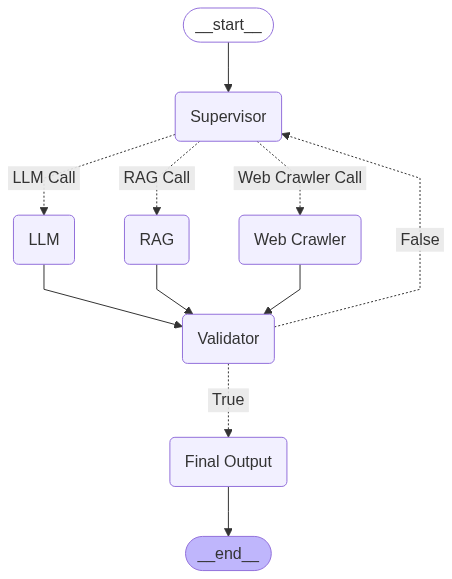

In [22]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [23]:
state={"messages":["What is framing in photography?"]}
app.invoke(state)

-> Inside Supervisor Function <-
Parsed response Topic='Wildlife Photography' Reasoning='The query asks about a fundamental photographic concept, framing, which is relevant to wildlife photography.'
-> Inside Function Router <-
last_message: Wildlife Photography
-> Inside RAG Node <-
-> Inside Function Validator <-
context: ['Contents  vii\nUsing Lines, Shapes, and Patterns 158\nFraming Your Subject 162\nCreating Perspective 162\nConcealing to Draw Attention 164\nFrame Filling vs. Environmental Shots 165\nIncorporating Background 167\nApplying the Rule of Thirds 169\nChapter Assignments 171\nChapter 8: Beyond the Bas ICs 17 3\nGoing Beyond the Basics for Creative Control  \nover Your Images\nPoring Over the Picture 174\nPoring Over the Picture 176\nCreative Use of Exposur\ne Compensation 178\nWhen to Use Manual Exposure  180\n\nstyle. The lens you use (see Chapter 2, “Camera Settings and Shooting Techniques”) \nplays a big part in the types of wildlife photographs you make. How close y

{'messages': ['What is framing in photography?',
  'Wildlife Photography',
  'Framing in photography is the technique of using elements within the scene to create a boundary or focus around your subject. \n\n\n',
  True,
  'Framing in photography is the technique of using elements within the scene to create a boundary or focus around your subject. \n\n\n'],
 'contexts': ['Contents  vii\nUsing Lines, Shapes, and Patterns 158\nFraming Your Subject 162\nCreating Perspective 162\nConcealing to Draw Attention 164\nFrame Filling vs. Environmental Shots 165\nIncorporating Background 167\nApplying the Rule of Thirds 169\nChapter Assignments 171\nChapter 8: Beyond the Bas ICs 17 3\nGoing Beyond the Basics for Creative Control  \nover Your Images\nPoring Over the Picture 174\nPoring Over the Picture 176\nCreative Use of Exposur\ne Compensation 178\nWhen to Use Manual Exposure  180\n\nstyle. The lens you use (see Chapter 2, “Camera Settings and Shooting Techniques”) \nplays a big part in the type